# 4.12

三维一次（8结点）和三维二次（20结点）等参元，在x、y、z坐标中单元各边与坐标轴x、y、z平行，
边长为a、b、c，
在4.10题中的三种荷载条件下（假定荷载沿$\zeta$方向不变），
结点载荷向量各是什么？

In [1]:
import sympy
import finite_element
from sympy import *
from sympy.abc import *
sympy.init_printing()

In [2]:
b0, q0 = symbols('b_0 q_0')

## 三维一次等参元

计算位移插值函数。

In [3]:
local_coordinates = [
    (1,1,1), (1,1,-1), (1,-1,1), (1,-1,-1),
    (-1,1,1), (-1,1,-1), (-1,-1,1), (-1,-1,-1),    
]
Matrix(local_coordinates).T

⎡1  1   1   1   -1  -1  -1  -1⎤
⎢                             ⎥
⎢1  1   -1  -1  1   1   -1  -1⎥
⎢                             ⎥
⎣1  -1  1   -1  1   -1  1   -1⎦

In [4]:
surface_exclude = finite_element.interpolation.SurfaceExclude([xi, eta, zeta])
surface_exclude.add_surface(xi + 1)
surface_exclude.add_surface(xi - 1)
surface_exclude.add_surface(eta + 1)
surface_exclude.add_surface(eta - 1)
surface_exclude.add_surface(zeta + 1)
surface_exclude.add_surface(zeta - 1)
serendipity = finite_element.interpolation.Serendipity([xi, eta, zeta])
[serendipity.add_formula(surface_exclude.get_interpolation_function(coordinate), coordinate)
 for coordinate in local_coordinates]
interpolation_functions = [diag(1,1,1) * f for f in serendipity.formulas]
interpolation_functions = Matrix(interpolation_functions)
interpolation_functions.T

⎡(η + 1)⋅(ξ + 1)⋅(ζ + 1)                                                    -(
⎢───────────────────────             0                        0             ──
⎢           8                                                                 
⎢                                                                             
⎢                         (η + 1)⋅(ξ + 1)⋅(ζ + 1)                             
⎢           0             ───────────────────────             0               
⎢                                    8                                        
⎢                                                                             
⎢                                                  (η + 1)⋅(ξ + 1)⋅(ζ + 1)    
⎢           0                        0             ───────────────────────    
⎣                                                             8               

η + 1)⋅(ξ + 1)⋅(ζ - 1)                                                        
───────────────────────              0             

计算等参元坐标插值函数

In [5]:
global_coordinates = [(_x*a/2,_y*b/2,_z*c/2) for _x,_y,_z in local_coordinates]
Matrix(global_coordinates).T

⎡a   a    a    a   -a   -a   -a   -a ⎤
⎢─   ─    ─    ─   ───  ───  ───  ───⎥
⎢2   2    2    2    2    2    2    2 ⎥
⎢                                    ⎥
⎢b   b   -b   -b    b    b   -b   -b ⎥
⎢─   ─   ───  ───   ─    ─   ───  ───⎥
⎢2   2    2    2    2    2    2    2 ⎥
⎢                                    ⎥
⎢c  -c    c   -c    c   -c    c   -c ⎥
⎢─  ───   ─   ───   ─   ───   ─   ───⎥
⎣2   2    2    2    2    2    2    2 ⎦

In [6]:
isoparametric = finite_element.interpolation.Isoparametric(
    local_axises=[xi,eta,zeta],
    global_axises=[x,y,z],
    interpolation_functions=serendipity.formulas,
    coordinates=global_coordinates,
)
x,y,z = isoparametric.coordinate_interpolation_functions
x,y,z

计算$jacobian$和$A$两个坐标变换。

In [7]:
jacobian = Matrix([
    [x.diff(xi), y.diff(xi), z.diff(xi)],
    [x.diff(eta), y.diff(eta), z.diff(eta)],
    [x.diff(zeta), y.diff(zeta), z.diff(zeta)],    
]).det()
jacobian

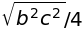

In [8]:
A = sqrt(
    (y.diff(eta) * z.diff(zeta) - y.diff(zeta) * z.diff(eta)) ** 2 +
    (z.diff(eta) * x.diff(zeta) - z.diff(zeta) * x.diff(eta)) ** 2 +
    (x.diff(eta) * y.diff(zeta) - x.diff(zeta) * y.diff(eta)) ** 2
)
A

手动调整A的值

In [9]:
A = b*c/4
A

### 情况1
在x正方向上有一分布载荷作用在$\xi=1$的边上，载荷在$\eta=-1$为零；在$\eta=1$为$q_0$，呈线性变化。

In [10]:
load = Matrix([
    q0/2+q0*eta/2,
    0,
    0,
])
load.T

⎡η⋅q₀   q₀      ⎤
⎢──── + ──  0  0⎥
⎣ 2     2       ⎦

In [11]:
integrate(integrate(
    interpolation_functions * load * A,
    (eta, -1, 1)), (zeta, -1, 1)).subs({xi: 1}).T

⎡b⋅c⋅q₀        b⋅c⋅q₀        b⋅c⋅q₀        b⋅c⋅q₀                             
⎢──────  0  0  ──────  0  0  ──────  0  0  ──────  0  0  0  0  0  0  0  0  0  
⎣  6             6             12            12                               

             ⎤
0  0  0  0  0⎥
             ⎦

### 情况2

在$\xi=1$边上作用有均布载荷$q_0$，方向压向单元。

In [12]:
load = Matrix([
    -q0,
    0,
    0,
])
load.T

[-q₀  0  0]

In [13]:
integrate(integrate(
    interpolation_functions * load * A,
    (eta, -1, 1)), (zeta, -1, 1)).subs({xi: 1}).T

⎡-b⋅c⋅q₀         -b⋅c⋅q₀         -b⋅c⋅q₀         -b⋅c⋅q₀                      
⎢────────  0  0  ────────  0  0  ────────  0  0  ────────  0  0  0  0  0  0  0
⎣   4               4               4               4                         

                     ⎤
  0  0  0  0  0  0  0⎥
                     ⎦

### 情况3

在$y$正方向作用有均布的体积力$b_0$。

In [14]:
load = Matrix([0, b0, 0])
load.T

[0  b₀  0]

In [15]:
integrate(integrate(integrate(
    interpolation_functions * load * jacobian,
    (eta, -1, 1)), (zeta, -1, 1)), (xi, -1, 1)).T

⎡   a⋅b⋅b₀⋅c        a⋅b⋅b₀⋅c        a⋅b⋅b₀⋅c        a⋅b⋅b₀⋅c        a⋅b⋅b₀⋅c  
⎢0  ────────  0  0  ────────  0  0  ────────  0  0  ────────  0  0  ────────  
⎣      8               8               8               8               8      

      a⋅b⋅b₀⋅c        a⋅b⋅b₀⋅c        a⋅b⋅b₀⋅c   ⎤
0  0  ────────  0  0  ────────  0  0  ────────  0⎥
         8               8               8       ⎦

## 三维二次等参元

计算位移插值函数。

In [16]:
local_coordinates = [
    (1,1,1), (1,1,-1), (1,-1,1), (1,-1,-1),
    (-1,1,1), (-1,1,-1), (-1,-1,1), (-1,-1,-1),
    (1,0,1), (0,1,1), (-1,0,1), (0,-1,1),
    (1,1,0), (1,-1,0), (-1,-1,0), (-1,1,0),
    (1,0,-1), (0,1,-1), (-1,0,-1), (0,-1,-1),
]
Matrix(local_coordinates).T

⎡1  1   1   1   -1  -1  -1  -1  1  0  -1  0   1  1   -1  -1  1   0   -1  0 ⎤
⎢                                                                          ⎥
⎢1  1   -1  -1  1   1   -1  -1  0  1  0   -1  1  -1  -1  1   0   1   0   -1⎥
⎢                                                                          ⎥
⎣1  -1  1   -1  1   -1  1   -1  1  1  1   1   0  0   0   0   -1  -1  -1  -1⎦

In [17]:
surface_exclude = finite_element.interpolation.SurfaceExclude([xi, eta, zeta])
surface_exclude.add_surface(xi + 1)
surface_exclude.add_surface(xi - 1)
surface_exclude.add_surface(eta + 1)
surface_exclude.add_surface(eta - 1)
surface_exclude.add_surface(zeta + 1)
surface_exclude.add_surface(zeta - 1)
serendipity = finite_element.interpolation.Serendipity([xi, eta, zeta])
[serendipity.add_formula(surface_exclude.get_interpolation_function(coordinate), coordinate)
 for coordinate in local_coordinates]
interpolation_functions = [diag(1,1,1) * f for f in serendipity.formulas]
interpolation_functions = Matrix(interpolation_functions)
interpolation_functions.T

⎡(η + 1)⋅(ξ + 1)⋅(ζ + 1)⋅(η + ξ + ζ - 2)                                      
⎢───────────────────────────────────────                     0                
⎢                   8                                                         
⎢                                                                             
⎢                                         (η + 1)⋅(ξ + 1)⋅(ζ + 1)⋅(η + ξ + ζ -
⎢                   0                     ────────────────────────────────────
⎢                                                            8                
⎢                                                                             
⎢                                                                             
⎢                   0                                        0                
⎣                                                                             

                                              -(η + 1)⋅(ξ + 1)⋅(ζ - 1)⋅(η + ξ 
                        0                     ─────

计算等参元坐标插值函数

In [18]:
global_coordinates = [(_x*a/2,_y*b/2,_z*c/2) for _x,_y,_z in local_coordinates]
Matrix(global_coordinates).T

⎡a   a    a    a   -a   -a   -a   -a   a     -a        a   a   -a   -a    a   
⎢─   ─    ─    ─   ───  ───  ───  ───  ─  0  ───   0   ─   ─   ───  ───   ─   
⎢2   2    2    2    2    2    2    2   2      2        2   2    2    2    2   
⎢                                                                             
⎢b   b   -b   -b    b    b   -b   -b      b       -b   b  -b   -b    b        
⎢─   ─   ───  ───   ─    ─   ───  ───  0  ─   0   ───  ─  ───  ───   ─    0   
⎢2   2    2    2    2    2    2    2      2        2   2   2    2    2        
⎢                                                                             
⎢c  -c    c   -c    c   -c    c   -c   c  c   c    c                     -c   
⎢─  ───   ─   ───   ─   ───   ─   ───  ─  ─   ─    ─   0   0    0    0   ───  
⎣2   2    2    2    2    2    2    2   2  2   2    2                      2   

     -a      ⎤
 0   ───   0 ⎥
      2      ⎥
             ⎥
 b        -b ⎥
 ─    0   ───⎥
 2         2 ⎥
             ⎥
-c   -c   

In [19]:
isoparametric = finite_element.interpolation.Isoparametric(
    local_axises=[xi,eta,zeta],
    global_axises=[x,y,z],
    interpolation_functions=serendipity.formulas,
    coordinates=global_coordinates,
)
x,y,z = isoparametric.coordinate_interpolation_functions
x,y,z

计算$jacobian$和$A$两个坐标变换。

In [20]:
jacobian = Matrix([
    [x.diff(xi), y.diff(xi), z.diff(xi)],
    [x.diff(eta), y.diff(eta), z.diff(eta)],
    [x.diff(zeta), y.diff(zeta), z.diff(zeta)],    
]).det()
jacobian

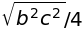

In [21]:
A = sqrt(
    (y.diff(eta) * z.diff(zeta) - y.diff(zeta) * z.diff(eta)) ** 2 +
    (z.diff(eta) * x.diff(zeta) - z.diff(zeta) * x.diff(eta)) ** 2 +
    (x.diff(eta) * y.diff(zeta) - x.diff(zeta) * y.diff(eta)) ** 2
)
A

手动调整A的值

In [22]:
A = b*c/4
A

出于篇幅考虑，以下省略y、z方向上的均为0的荷载分量。

In [23]:
interpolation_functions = Matrix(serendipity.formulas)

### 情况1
在x正方向上有一分布载荷作用在$\xi=1$的边上，载荷在$\eta=-1$为零；在$\eta=1$为$q_0$，呈线性变化。

In [24]:
load = Matrix([q0/2+q0*eta/2])
load.T

⎡η⋅q₀   q₀⎤
⎢──── + ──⎥
⎣ 2     2 ⎦

In [25]:
integrate(integrate(
    interpolation_functions * load * A,
    (eta, -1, 1)), (zeta, -1, 1)).subs({xi: 1}).T

⎡-b⋅c⋅q₀   -b⋅c⋅q₀   -b⋅c⋅q₀   -b⋅c⋅q₀               b⋅c⋅q₀           2⋅b⋅c⋅q₀
⎢────────  ────────  ────────  ────────  0  0  0  0  ──────  0  0  0  ────────
⎣   36        36        18        18                   6                 9    

  b⋅c⋅q₀        b⋅c⋅q₀         ⎤
  ──────  0  0  ──────  0  0  0⎥
    9             6            ⎦

### 情况2

在$\xi=1$边上作用有均布载荷$q_0$，方向压向单元。

In [26]:
load = Matrix([-q0])
load.T

[-q₀]

In [27]:
integrate(integrate(
    interpolation_functions * load * A,
    (eta, -1, 1)), (zeta, -1, 1)).subs({xi: 1}).T

⎡b⋅c⋅q₀  b⋅c⋅q₀  b⋅c⋅q₀  b⋅c⋅q₀              -b⋅c⋅q₀            -b⋅c⋅q₀   -b⋅c
⎢──────  ──────  ──────  ──────  0  0  0  0  ────────  0  0  0  ────────  ────
⎣  12      12      12      12                   3                  3         3

⋅q₀         -b⋅c⋅q₀          ⎤
────  0  0  ────────  0  0  0⎥
               3             ⎦

### 情况3

在$y$正方向作用有均布的体积力$b_0$。

In [28]:
load = Matrix([b0])
load.T

[b₀]

In [29]:
integrate(integrate(integrate(
    interpolation_functions * load * jacobian,
    (eta, -1, 1)), (zeta, -1, 1)), (xi, -1, 1)).T

⎡-a⋅b⋅b₀⋅c   -a⋅b⋅b₀⋅c   -a⋅b⋅b₀⋅c   -a⋅b⋅b₀⋅c   -a⋅b⋅b₀⋅c   -a⋅b⋅b₀⋅c   -a⋅b⋅
⎢──────────  ──────────  ──────────  ──────────  ──────────  ──────────  ─────
⎣    8           8           8           8           8           8           8

b₀⋅c   -a⋅b⋅b₀⋅c   a⋅b⋅b₀⋅c  a⋅b⋅b₀⋅c  a⋅b⋅b₀⋅c  a⋅b⋅b₀⋅c  a⋅b⋅b₀⋅c  a⋅b⋅b₀⋅c 
─────  ──────────  ────────  ────────  ────────  ────────  ────────  ──────── 
           8          6         6         6         6         6         6     

 a⋅b⋅b₀⋅c  a⋅b⋅b₀⋅c  a⋅b⋅b₀⋅c  a⋅b⋅b₀⋅c  a⋅b⋅b₀⋅c  a⋅b⋅b₀⋅c⎤
 ────────  ────────  ────────  ────────  ────────  ────────⎥
    6         6         6         6         6         6    ⎦